In [1]:
%cd ..

/mnt/e/projects/face_recognition


In [2]:
import os
import types
from collections import defaultdict

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from IPython.display import clear_output
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.models import efficientnet_v2_s

from config import CFG

device = "cuda"

In [3]:
def get_dataset_and_filter_by_label_trashold_for_irt(label_trashold):
    df_identity = pd.read_csv(CFG.identity_path, sep=" ", header=None).sort_values(by=0).reset_index(drop=True)
    df_identity.columns = ["image", "label"]
    cropped_imgs = os.listdir(CFG.img_folder_dst)
    data = pd.DataFrame({"image": cropped_imgs})
    data = data.join(df_identity.set_index("image"), on="image", how="left")
    data_tmp = data.groupby(["label"]).agg({"label": "count"}).rename(columns={"label": "label_count"})
    print(f"Число уникальных людей {len(data_tmp)}, каждый человек имеет, как минимум {label_trashold} фоток.")

    del_label = data_tmp.loc[data_tmp.label_count <= label_trashold, :].index.values
    mask = data["label"].isin(set(del_label))

    data_train = data[~mask].reset_index(drop=True)
    print(f"Всего фоток в data_train {len(data_train)}")
    df_labels = data_train["label"].unique()
    map_lables = {l: i for i, l in enumerate(df_labels)}
    data_train["label"] = data_train["label"].map(lambda x: map_lables[x])

    data_irm = data[mask].reset_index(drop=True)
    print(f"Всего фоток в data_irm {len(data_irm)}")
    df_labels = data_irm["label"].unique()
    map_lables = {l: i for i, l in enumerate(df_labels)}
    data_irm["label"] = data_irm["label"].map(lambda x: map_lables[x])

    return data_train, data_irm


def split_dataset_by_photo(df, label_col, num_val_samples_per_class):
    validation_data = []
    train_data = []
    test_data = []

    for label in df[label_col].unique():
        label_data = df[df[label_col] == label]

        val_samples = label_data.sample(num_val_samples_per_class)
        validation_data.append(val_samples)
        label_data = label_data.drop(val_samples.index)

        test_samples = label_data.sample(num_val_samples_per_class)
        test_data.append(test_samples)
        label_data = label_data.drop(test_samples.index)

        train_data.append(label_data)

    train_df = pd.concat(train_data).reset_index(drop=True)
    validation_df = pd.concat(validation_data).reset_index(drop=True)
    test_df = pd.concat(test_data).reset_index(drop=True)
    print(f"df({len(df)}) -> train({len(train_df)}) val({len(validation_df)}) test({len(test_df)})")

    return train_df, validation_df, test_df


# Split the dataset

data, data_irm = get_dataset_and_filter_by_label_trashold_for_irt(label_trashold=CFG.label_trashold)

df_train, df_val, df_test = split_dataset_by_photo(data, "label", 4)

Число уникальных людей 10174, каждый человек имеет, как минимум 28 фоток.
Всего фоток в data_train 59959
Всего фоток в data_irm 134757
df(59959) -> train(43767) val(8096) test(8096)


In [4]:
data.groupby(["label"]).agg({"label": "count"}).rename(columns={"label": "label_count"}).sort_values(
    by="label_count", ascending=True
).head(2)

,label_count
label,
5,29
6,29


In [5]:
data_irm.groupby(["label"]).agg({"label": "count"}).rename(columns={"label": "label_count"}).sort_values(
    by="label_count", ascending=False
).head(2)

,label_count
label,
2931,28
2919,28


In [6]:
def split_by_person(data_irm: pd.DataFrame):
    """
    Сплит по людям
    итак train_baseline тренили на 2024 людях
    для irm возмём 200(40 query + 160 distractors) людей
    и у них по 3 фоток

    TODO: Отрефакотрить что бы всё красиво было, а не руками задавали
    """

    data_label_count = (
        data_irm.groupby(["label"])
        .agg({"label": "count"})
        .rename(columns={"label": "label_count"})
        .sort_values(by="label_count", ascending=False)
    )

    query_label_set = data_label_count.head(40)
    data_label_count = data_label_count.drop(query_label_set.index)
    distractors_label_set = data_label_count.head(160)

    query_list = []
    distractors_list = []

    for label in query_label_set.index:
        label_data = data_irm[data_irm["label"] == label]
        query_list.append(label_data.sample(3))

    for label in distractors_label_set.index:
        label_data = data_irm[data_irm["label"] == label]
        distractors_list.append(label_data.sample(3))

    query_df = pd.concat(query_list).reset_index(drop=True)
    distractors_df = pd.concat(distractors_list).reset_index(drop=True)
    # проверка что датасеты не пересекаются
    assert bool(set(query_df["label"]) & set(distractors_df["label"])) is False

    return query_df, distractors_df


query_df, distractors_df = split_by_person(data_irm)

In [7]:
query_df.head(5)

,image,label
0,068313.jpg,2931
1,152125.jpg,2931
2,080835.jpg,2931
3,070294.jpg,2919
4,060299.jpg,2919


In [8]:
query_img_names = [os.path.join(CFG.img_folder_dst, x) for x in query_df["image"].values]

query_dict = defaultdict(list)
for img_name, img_class in query_df.values:
    query_dict[img_class].append(img_name)

distractors_img_names = [os.path.join(CFG.img_folder_dst, x) for x in distractors_df["image"].values]

In [9]:
best_model = efficientnet_v2_s()
best_model.classifier = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(in_features=1280, out_features=2024))
best_model.load_state_dict(torch.load("models/efficientnet_v2_s_ce_10_epoch.pth"))
best_model.classifier = nn.Sequential()
best_model.eval()
None

In [10]:
class celebAIrDataset(Dataset):
    def __init__(self, images_list):
        self.images = images_list
        self.transform = A.Compose(
            [
                # A.Resize(height=128, width=128),
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                ToTensorV2(),
            ]
        )

    def __len__(self):
        return len(self.images)

    def get_img(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return self.transform(image=img)["image"]

    def get_tensors(self):
        images = torch.stack([self.get_img(img_name) for img_name in self.images])
        return images

    def __getitem__(self, idx):
        img_name = self.images[idx]
        return self.get_img(img_name)

In [11]:
def compute_embeddings(model, images_list):
    """
    compute embeddings from the trained model for list of images.
    params:
      model: trained nn model that takes images and outputs embeddings
      images_list: list of images paths to compute embeddings for
    output:
      list: list of model embeddings. Each embedding corresponds to images
            names from images_list
    """
    data = celebAIrDataset(images_list)

    model.to(device)

    # loader = torch.utils.data.DataLoader(data.get_tensors(), batch_size=32, shuffle=False)
    loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=False)

    model.eval()
    embeddings = []
    with torch.no_grad():
        for x in loader:
            outputs = model(x.to(device))
            embeddings.append(outputs.cpu())
    return torch.cat(embeddings)

In [12]:
query_embeddings = compute_embeddings(best_model, query_img_names)
distractors_embeddings = compute_embeddings(best_model, distractors_img_names)

In [13]:
distractors_embeddings.size(), query_embeddings.size()

(torch.Size([480, 1280]), torch.Size([120, 1280]))

In [14]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    """
    compute cosine similarities between positive pairs from query (stage 1)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to the same people from query list
    """
    full_embeddings = torch.Tensor()

    for person_class in query_dict:
        images = [os.path.join(CFG.img_folder_dst, x) for x in query_dict[person_class]]
        person_embeddings = []
        for image_path in images:
            person_embeddings.append(torch.Tensor(query_embeddings[query_img_names.index(image_path)]))
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
            result = 0.0
        else:
            person_embeddings = torch.stack(person_embeddings)
            result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
            df = pd.DataFrame(result)

            df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
            useful_result = df[~np.isnan(df)]  # drop nan

            useful_result = torch.Tensor(useful_result).view(-1)
            full_embeddings = torch.cat((full_embeddings, useful_result))
    results = [i.item() for i in full_embeddings]
    plt.hist(results)
    plt.show()
    print("Count of cosine similarities =", len(results))
    return results

In [15]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    """
    compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to different people from query list
    """

    full_embeddings = torch.Tensor()
    class_counter = []

    k = 0
    for person_class in query_dict:
        k += 1
        print("Analyse {} person of {}...".format(k, len(query_dict)))
        images = [os.path.join(CFG.img_folder_dst, x) for x in query_dict[person_class]]
        class_counter.extend([person_class for _ in range(len(images))])

        person_embeddings = []
        for image_path in images:
            person_embeddings.append(torch.Tensor(query_embeddings[query_img_names.index(image_path)]))
        if len(person_embeddings) == 0:
            person_embeddings = torch.Tensor
        else:
            person_embeddings = torch.stack(person_embeddings)
            full_embeddings = torch.cat((full_embeddings, person_embeddings))
        clear_output(wait=True)

    # all_data = pd.DataFrame(data={"class": class_counter, "embeddings": list(full_embeddings)})
    results = cosine_similarity(full_embeddings, full_embeddings)
    results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

    k = 0
    for i in results:
        k += 1
        print("Analyse {} row of {}...".format(k, len(results)))
        results.loc[i, i] = np.nan
        clear_output(wait=True)

    df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1)  # get triangle values
    useful_result = df[~np.isnan(df)]  # drop nan
    plt.hist(useful_result)
    plt.show()
    print("Count of cosine similarities =", len(useful_result))
    return useful_result

In [16]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    """
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
      query_embeddings: list of embeddings corresponding to query_img_names
      distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
      list of floats: similarities between pairs of people (q, d), where q is
                      embedding corresponding to photo from query, d —
                      embedding corresponding to photo from distractors
    """
    results = cosine_similarity(query_embeddings, distractors_embeddings)
    results = results.reshape(-1)
    plt.hist(results)
    plt.show()
    print("Count of cosine similarities =", len(results))
    return results

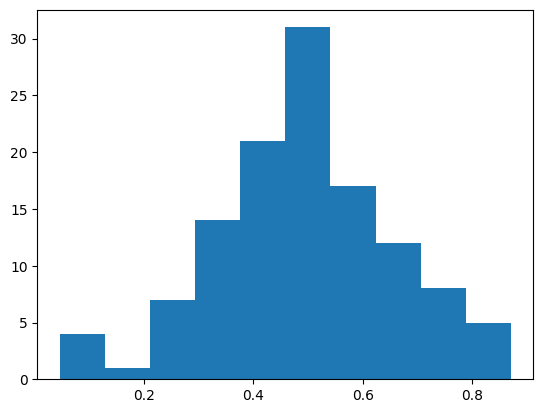

Count of cosine similarities = 120


In [17]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)

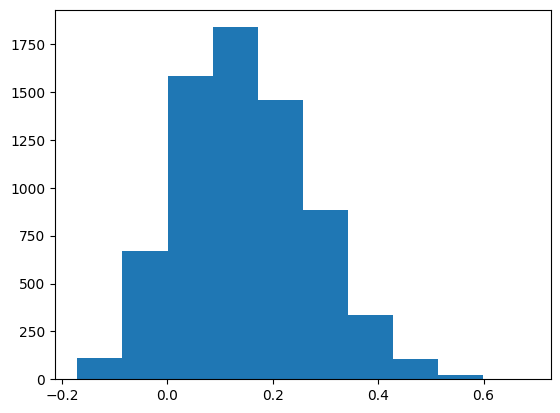

Count of cosine similarities = 7020


In [18]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)

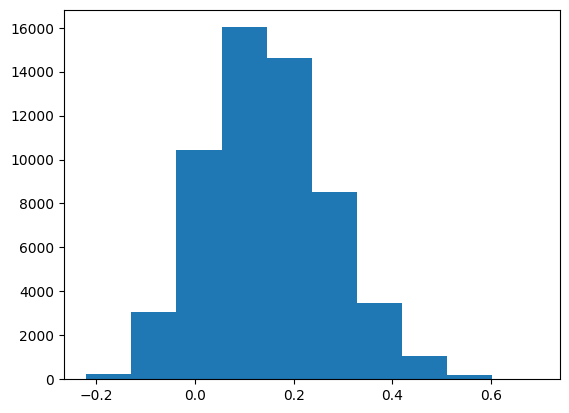

Count of cosine similarities = 57600


In [19]:
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

In [30]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    """
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
      cosine_query_pos: cosine similarities between positive pairs from query
      cosine_query_neg: cosine similarities between negative pairs from query
      cosine_query_distractors: cosine similarities between negative pairs
                                from query and distractors
      fpr: false positive rate at which to compute TPR
    output:
      float: threshold for given fpr
      float: TPR at given FPR
    """
    cosine_query_pos = torch.Tensor(cosine_query_pos)
    cosine_query_neg = torch.Tensor(cosine_query_neg)
    cosine_query_distractors = torch.Tensor(cosine_query_distractors)

    false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
    N = round(fpr * len(false_pairs))
    false_pairs = torch.sort(false_pairs, descending=True)[0]
    threshold = false_pairs[N]
    TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
    return threshold.item(), TPR

In [31]:
# фух компуктер не взорвался, но моя голова да
for frp in [0.5, 0.2, 0.1, 0.05]:
    print(compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, frp))

(0.14049921929836273, 0.9583333333333334)
(0.25158241391181946, 0.9333333333333333)
(0.31288713216781616, 0.8833333333333333)
(0.36539188027381897, 0.7916666666666666)
